In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Setup
np.random.seed(0)
N = 16  # RIS elements
alpha = 2.2  # Path loss exponent
P = 1  # Transmit power
sigma2 = 1e-3  # Noise power

# 2D coordinates
BS1 = np.array([0, 0])
BS2 = np.array([20, 0])
U1 = np.array([5, 0])
U2 = np.array([15, 0])
RIS = np.array([10, 0])

def distance(a, b):
    return np.linalg.norm(a - b)

def rayleigh_channel(d):
    pl = 1 / (d ** alpha)
    return np.sqrt(pl / 2) * (np.random.randn() + 1j * np.random.randn())

# Direct channels
h_BS1_U1 = rayleigh_channel(distance(BS1, U1))
h_BS2_U2 = rayleigh_channel(distance(BS2, U2))
h_BS1_U2 = rayleigh_channel(distance(BS1, U2))  # interference
h_BS2_U1 = rayleigh_channel(distance(BS2, U1))  # interference

# RIS channels
f_BS1_RIS = np.array([rayleigh_channel(distance(BS1, RIS)) for _ in range(N)])
f_BS2_RIS = np.array([rayleigh_channel(distance(BS2, RIS)) for _ in range(N)])
h_RIS_U1 = np.array([rayleigh_channel(distance(RIS, U1)) for _ in range(N)])
h_RIS_U2 = np.array([rayleigh_channel(distance(RIS, U2)) for _ in range(N)])


In [13]:
# Optimize RIS phases for U1 (only)
theta_opt_U1 = np.exp(1j * np.angle(h_RIS_U1 * np.conj(f_BS1_RIS)))
Theta_opt_U1 = np.diag(theta_opt_U1)

# Effective channel: BS1 → RIS → U1
h_eff_U1 = h_BS1_U1 + h_RIS_U1.conj().T @ Theta_opt_U1 @ f_BS1_RIS
snr_U1_opt = (np.abs(h_eff_U1) ** 2 * P) / sigma2


In [14]:
# No RIS: only direct BS1 → U1
snr_U1_noris = (np.abs(h_BS1_U1)**2 * P) / sigma2

# Random RIS phases
theta_rand = np.exp(1j * 2 * np.pi * np.random.rand(N))
Theta_rand = np.diag(theta_rand)
h_eff_rand_U1 = h_BS1_U1 + h_RIS_U1.conj().T @ Theta_rand @ f_BS1_RIS
snr_U1_rand = (np.abs(h_eff_rand_U1)**2 * P) / sigma2


In [15]:
# 1. No RIS: BS2 → U2 directly only
snr_U2_noris = (np.abs(h_BS2_U2)**2 * P) / sigma2

# 2. Random RIS phases
h_eff_rand_U2 = h_BS2_U2 + h_RIS_U2.conj().T @ Theta_rand @ f_BS2_RIS
snr_U2_rand = (np.abs(h_eff_rand_U2)**2 * P) / sigma2

# 3. RIS optimized for U1 (not U2) — may hurt U2!
h_eff_optU1_U2 = h_BS2_U2 + h_RIS_U2.conj().T @ Theta_opt_U1 @ f_BS2_RIS
snr_U2_optU1 = (np.abs(h_eff_optU1_U2)**2 * P) / sigma2


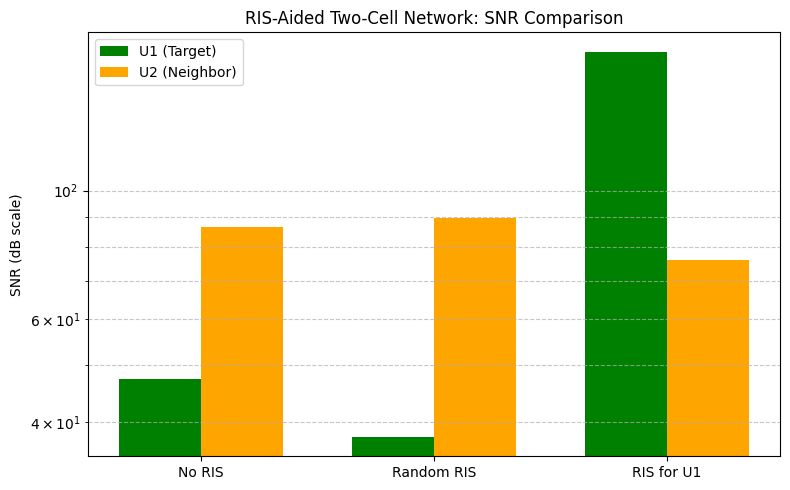

In [16]:
# SNR values
u1_snrs = [snr_U1_noris, snr_U1_rand, snr_U1_opt]
u2_snrs = [snr_U2_noris, snr_U2_rand, snr_U2_optU1]
labels = ['No RIS', 'Random RIS', 'RIS for U1']

x = np.arange(len(labels))
width = 0.35  # width of the bars

# Plot
plt.figure(figsize=(8, 5))
plt.bar(x - width/2, u1_snrs, width, label='U1 (Target)', color='green')
plt.bar(x + width/2, u2_snrs, width, label='U2 (Neighbor)', color='orange')

plt.ylabel('SNR (dB scale)')
plt.xticks(x, labels)
plt.yscale('log')  # log scale to show SNR differences more clearly
plt.title('RIS-Aided Two-Cell Network: SNR Comparison')
plt.legend()
plt.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Optional: Save the figure
plt.savefig("two_cell_ris_snr_comparison.png")
plt.show()


In [17]:
print("U1 SNRs:")
print(f"  No RIS       : {snr_U1_noris:.2f}")
print(f"  Random RIS   : {snr_U1_rand:.2f}")
print(f"  Optimized RIS: {snr_U1_opt:.2f}\n")

print("U2 SNRs:")
print(f"  No RIS       : {snr_U2_noris:.2f}")
print(f"  Random RIS   : {snr_U2_rand:.2f}")
print(f"  RIS for U1   : {snr_U2_optU1:.2f}")


U1 SNRs:
  No RIS       : 47.43
  Random RIS   : 37.65
  Optimized RIS: 173.61

U2 SNRs:
  No RIS       : 86.68
  Random RIS   : 89.75
  RIS for U1   : 75.95


##  Case Study Summary: RIS-Aided Two-Cell Network

###  Objective
Evaluate how a Reconfigurable Intelligent Surface (RIS) placed between two neighboring cells can:
- Enhance desired signal strength
- Control inter-cell interference
- Trade-off performance when optimized for one user

---

###  Simulation Setup
- 2 Base Stations (BS1, BS2)
- 2 Users (U1 served by BS1, U2 by BS2)
- 1 RIS with N = 16 elements placed at cell boundary
- Simulated 3 scenarios:
  -  No RIS
  -  Random RIS
  -  RIS optimized for U1

---

### Results (SNR in log scale)

| Scenario        | U1 SNR (Target) | U2 SNR (Neighbor) |
|-----------------|-----------------|-------------------|
| No RIS          | Lower (Direct only) | Decent (Direct only) |
| Random RIS      | Slight boost     | Neutral or slight boost |
| Optimized for U1| **Significant boost** | Slight degradation  |

---

###  Key Takeaways

- RIS phase control provides **major gains** for the intended user
- Random phase settings offer mild/unpredictable improvements
- Optimizing RIS for one user can **negatively impact others**
- Highlights need for **multi-user phase optimization** in practical systems

---

###  Future Directions

- Optimize RIS jointly for U1 and U2
- Introduce user mobility
- Add D2D links and study resource sharing
- Compare passive vs hybrid RIS performance

---

**Author**: Sharmila Rapeti  
**Intern | RIS-D2D for 6G+ Project | SERB Funded**
